In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/colab_final_project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/colab_final_project


In [2]:
!pip install "tensorflow-text"
!pip install protobuf
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 37.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [31]:
pip show protobuf

Name: protobuf
Version: 3.20.3
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: 
Author-email: 
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: google-api-core, google-cloud-bigquery, google-cloud-bigquery-connection, google-cloud-bigquery-storage, google-cloud-datastore, google-cloud-firestore, google-cloud-functions, google-cloud-language, google-cloud-translate, googleapis-common-protos, grpc-google-iam-v1, grpcio-status, proto-plus, tensorboard, tensorflow, tensorflow-datasets, tensorflow-hub, tensorflow-metadata


In [30]:
pip show tensorflow_text

Name: tensorflow-text
Version: 2.13.0
Summary: TF.Text is a TensorFlow library of text related ops, modules, and subgraphs.
Home-page: http://github.com/tensorflow/text
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: tensorflow, tensorflow-hub
Required-by: 


In [3]:
import re
from itertools import cycle
import json
import urllib.request

import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
train_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])
test_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/test.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])
val_df = pd.read_csv("https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/dev.tsv", sep='\t', header=None, usecols=[0, 1], names=["Text", "Emotion"])

In [5]:
# Downlaod Emotion List and Ekman Mapping

with urllib.request.urlopen('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt') as f:
  # Read the contents of the Emotions txt file
  emotion_list = f.read().decode().split("\n")

with urllib.request.urlopen('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/ekman_mapping.json') as f:
    # Read the contents of the ekman_mapping json file
    contents = f.read()

    # Parse the JSON data
    ekman_mapping = json.loads(contents)
    ekman_mapping["neutral"] = ["neutral"]

# Reverse the ekman mapping
ekman_dict = {v:k for k, values in ekman_mapping.items() for v in values}

In [6]:
train_df.head()

,Text,Emotion
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [7]:
emotion_list

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [8]:
ekman_dict

{'anger': 'anger',
 'annoyance': 'anger',
 'disapproval': 'anger',
 'disgust': 'disgust',
 'fear': 'fear',
 'nervousness': 'fear',
 'joy': 'joy',
 'amusement': 'joy',
 'approval': 'joy',
 'excitement': 'joy',
 'gratitude': 'joy',
 'love': 'joy',
 'optimism': 'joy',
 'relief': 'joy',
 'pride': 'joy',
 'admiration': 'joy',
 'desire': 'joy',
 'caring': 'joy',
 'sadness': 'sadness',
 'disappointment': 'sadness',
 'embarrassment': 'sadness',
 'grief': 'sadness',
 'remorse': 'sadness',
 'surprise': 'surprise',
 'realization': 'surprise',
 'confusion': 'surprise',
 'curiosity': 'surprise',
 'neutral': 'neutral'}

In [9]:
def get_emotion(emotion_label):
    """Function to replace emotions labels with the simplified ekamn mapping"""
    emotion_label = emotion_label.split(",")[0]
    emotion = emotion_list[int(emotion_label)]
    # return emotion after ekman mapping
    return ekman_dict[emotion]

train_df["Emotion"] = train_df["Emotion"].apply(get_emotion)
test_df["Emotion"] = test_df["Emotion"].apply(get_emotion)
val_df["Emotion"] = val_df["Emotion"].apply(get_emotion)

In [10]:
train_df["Emotion"].unique()

array(['neutral', 'anger', 'fear', 'surprise', 'joy', 'sadness',
       'disgust'], dtype=object)

In [11]:
train_df["Emotion"].value_counts()

joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: Emotion, dtype: int64

In [12]:
train_df = train_df.drop_duplicates("Text")
test_df = test_df.drop_duplicates("Text")
val_df = val_df.drop_duplicates("Text")

In [13]:
def filter_rows_by_values(df, column, value_list):
    """This function filters out rows containing a certian value/values """
    return df[~df[column].isin(value_list)]
train_df = filter_rows_by_values(train_df, "Emotion", ["fear", "disgust"])
test_df = filter_rows_by_values(test_df, "Emotion", ["fear", "disgust"])
val_df = filter_rows_by_values(val_df, "Emotion", ["fear", "disgust"])

In [14]:
train_df["Emotion"].unique()

array(['neutral', 'anger', 'surprise', 'joy', 'sadness'], dtype=object)

In [ ]:
oh = preprocessing.OneHotEncoder()
y_train = oh.fit_transform(train_df["Emotion"].values.reshape(-1,1))
y_test = oh.transform(test_df["Emotion"].values.reshape(-1,1))
y_val = oh.transform(val_df["Emotion"].values.reshape(-1,1))

In [16]:
# Convert sparse matrices to tensors so that it can be used for model training

y_train = tf.convert_to_tensor(csr_matrix(y_train).todense(), tf.float32)
y_test = tf.convert_to_tensor(csr_matrix(y_test).todense(), tf.float32)
y_val = tf.convert_to_tensor(csr_matrix(y_val).todense(), tf.float32)

In [17]:
train_ds =  tf.data.Dataset.from_tensor_slices((train_df["Text"], y_train)).shuffle(buffer_size=1000).batch(64)
val_ds =  tf.data.Dataset.from_tensor_slices((val_df["Text"], y_val)).shuffle(buffer_size=1000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["Text"], y_test))

In [18]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Text: {text_batch.numpy()[i]}')
    label = np.argmax(label_batch.numpy()[i])
    print(f'Label : {label} ({oh.categories_[0][label]})')

Text: b'Aren\xe2\x80\x99t people on the internet the best! I don\xe2\x80\x99t blame you for deleting, no time for negativity in this life. \xf0\x9f\x8d\xbb '
Label : 4 (surprise)
Text: b'She has at least 12 elbows and all of them are happy. You get it gurl'
Label : 1 (joy)
Text: b"I wouldn't let a sweet potato dictate decisions, ever."
Label : 0 (anger)


In [19]:
# We will be using the 'ssmall_bert/bert_en_uncased_L-2_H-128_A-2' model

tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [20]:
def build_bert_model():
  """Function which returns a built model"""

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessor = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
        trainable=True,
        name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(32, activation="relu")(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation="softmax", name='classifier')(net)

  return tf.keras.Model(text_input, net)
model = build_bert_model()

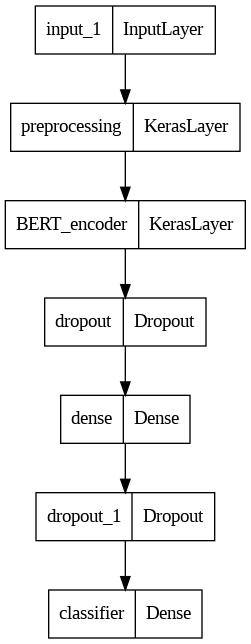

In [21]:
tf.keras.utils.plot_model(model)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer="adam", loss=loss, metrics="accuracy")
history = model.fit(x=train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
657/657 [==============================] - 760s 1s/step - loss: 1.1188 - accuracy: 0.5786 - val_loss: 1.0047 - val_accuracy: 0.6045
Epoch 2/10
657/657 [==============================] - 703s 1s/step - loss: 0.9878 - accuracy: 0.6316 - val_loss: 0.9718 - val_accuracy: 0.6223
Epoch 3/10
657/657 [==============================] - 739s 1s/step - loss: 0.9212 - accuracy: 0.6524 - val_loss: 0.9699 - val_accuracy: 0.6275
Epoch 4/10
657/657 [==============================] - 743s 1s/step - loss: 0.8519 - accuracy: 0.6823 - val_loss: 0.9924 - val_accuracy: 0.6191
Epoch 5/10
657/657 [==============================] - 717s 1s/step - loss: 0.7732 - accuracy: 0.7136 - val_loss: 1.0558 - val_accuracy: 0.6144
Epoch 6/10
657/657 [==============================] - 754s 1s/step - loss: 0.7015 - accuracy: 0.7404 - val_loss: 1.1709 - val_accuracy: 0.6077


In [23]:
save_path = '/content/drive/MyDrive/colab_final_project/savedModels/TransformerSentiment'
model.save(save_path)

In [24]:
save_path = '/content/drive/MyDrive/colab_final_project/savedModels/TransformerSentimentHDF5.h5'
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
test_predictions = model.predict(test_df["Text"])
# Get the Single labels from predction instead of an array of probabilities
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = np.argmax(y_test, axis=1)
test_acc = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy is {test_acc*100}%")

164/164 [==============================] - 28s 163ms/step
Test Accuracy is 59.93901276920145%


In [26]:
# Classification Report
print(classification_report(test_labels, test_predictions, target_names=oh.categories_[0]))

              precision    recall  f1-score   support

       anger       0.40      0.62      0.49       703
         joy       0.72      0.77      0.75      2049
     neutral       0.59      0.45      0.51      1605
     sadness       0.54      0.41      0.46       317
    surprise       0.53      0.48      0.50       573

    accuracy                           0.60      5247
   macro avg       0.56      0.55      0.54      5247
weighted avg       0.61      0.60      0.60      5247



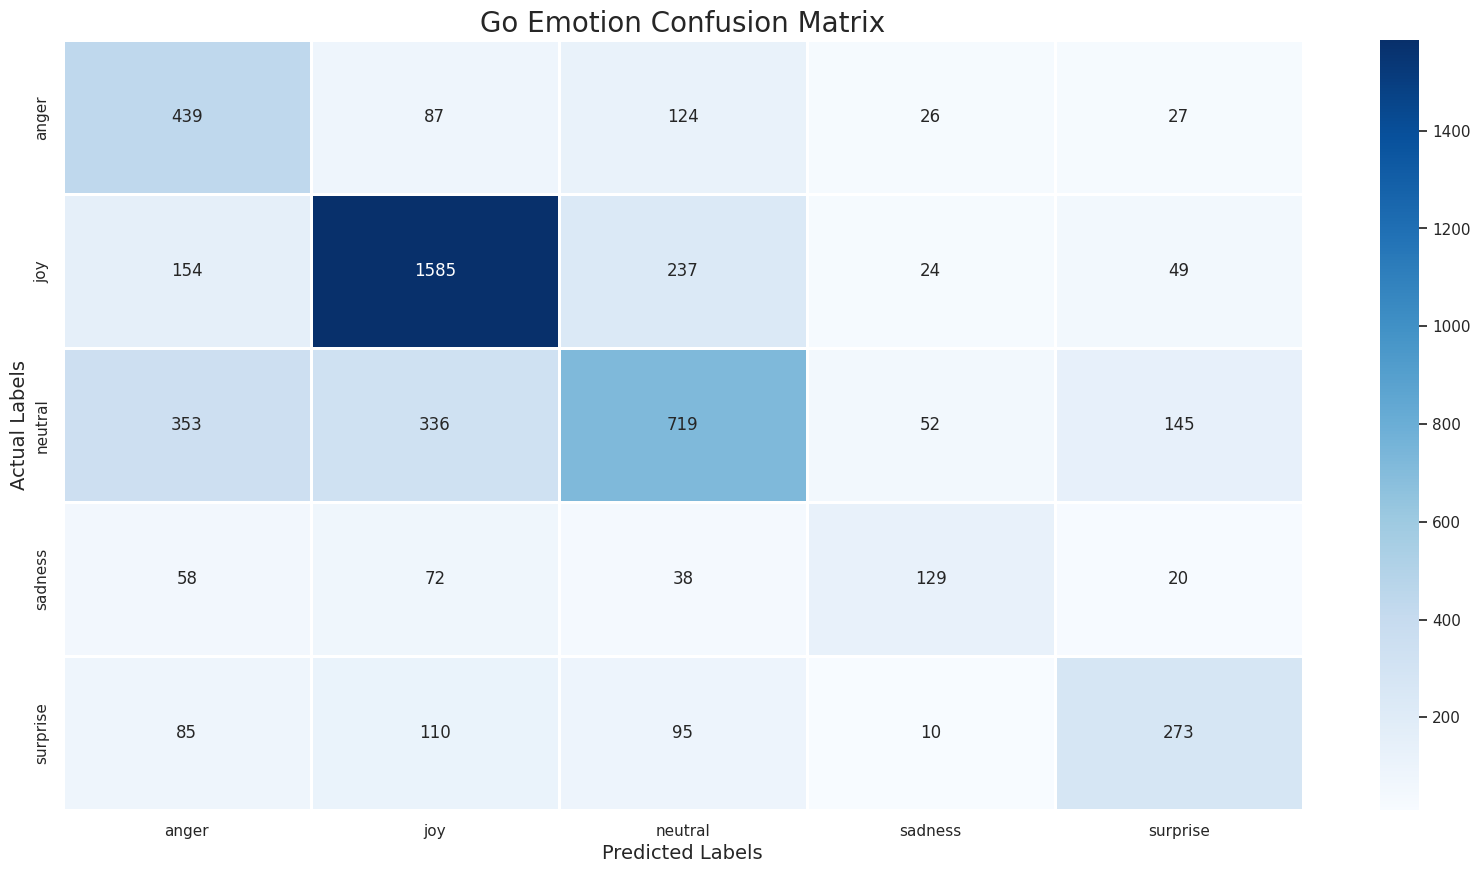

In [27]:
def plot_confusion_matrix(y_test, y_pred, labels=oh.categories_[0]):
    """
    Plot the confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (20, 10))
    cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
    sns.set(font_scale=1)
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Go Emotion Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()
plot_confusion_matrix( test_labels, test_predictions)

In [32]:
%cd drive/MyDrive/colab_final_project/

/content/drive/MyDrive/colab_final_project


In [33]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


emoji_dict = {}
with open('emoji.txt', 'r', encoding='latin-1') as emoji_file:
    for line in emoji_file:
        line = line.strip()
        if line:
            emoji, value = line.split('\t')
            emoji_dict[emoji] = int(value)
def replace_emojis(text, emoji_dict):
    for emoji, value in emoji_dict.items():
        if value == 1:
            text = re.sub(re.escape(emoji), 'happy', text)
        elif value == -1:
            text = re.sub(re.escape(emoji), 'sad', text)
    return text
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    words = word_tokenize(text)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    lemmatizer = WordNetLemmatizer()
    tagged = pos_tag(words)
    words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) if get_wordnet_pos(pos) else word for word, pos in tagged]
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
import io
input_df = pd.read_csv('firstIter.csv')

In [36]:
import random
from langdetect import detect
num_texts = 50  # Number of texts to fetch
testCorpus = []

texts = input_df["Comment Text"].tolist()
random.shuffle(texts)

for text in texts:
    try:
        lang = detect(text)
    except:
        lang = ""
    if lang == "en":
        newText = text.strip()
        newText = replace_emojis(newText, emoji_dict)
        newText = preprocess_text(newText)
        testCorpus.append(newText)
        if len(testCorpus) == num_texts:
            break

testCorpus = pd.Series(testCorpus)

In [37]:
myModel =tf.keras.models.load_model("savedModels/TransformerSentiment")
myPredictions = myModel.predict(testCorpus)
myPredictions = np.argmax(myPredictions, axis=1)

2/2 [==============================] - 1s 134ms/step


In [38]:
print(myPredictions)

[2 2 2 2 2 2 2 0 1 1 2 1 2 0 0 1 1 2 0 0 1 1 2 1 2 1 1 1 1 2 1 2 1 2 2 1 2
 2 2 2 0 2 2 2 1 1 2 2 2 1]


In [43]:
emotion_mapping = {
    0: ["anger", "annoyance", "disapproval"],
    1: ["joy", "amusement", "approval", "excitement", "gratitude", "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
    2: ["neutral"],
    3: ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    4: ["surprise", "realization", "confusion", "curiosity"]
}
decoded_predictions = [emotion_mapping[prediction] for prediction in myPredictions]
decoded_predictions

[['neutral'],
 ['neutral'],
 ['neutral'],
 ['neutral'],
 ['neutral'],
 ['neutral'],
 ['neutral'],
 ['anger', 'annoyance', 'disapproval'],
 ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 ['neutral'],
 ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 ['neutral'],
 ['anger', 'annoyance', 'disapproval'],
 ['anger', 'annoyance', 'disapproval'],
 ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admirat

In [40]:
!pip freeze > requirements.txt

In [46]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=13869d619b62aa954cf865c7101950f906be3a58dbf96909d51bb147504c79ae
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [48]:
!pipreqs . --force

ERROR: Failed on file: ./models/research/cognitive_planning/train_supervised_active_vision.py
Traceback (most recent call last):
  File "/usr/local/bin/pipreqs", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 528, in main
    init(args)
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 455, in init
    candidates = get_all_imports(input_path,
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 131, in get_all_imports
    raise exc
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 117, in get_all_imports
    tree = ast.parse(contents)
  File "/usr/lib/python3.10/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 185
    print inputs
    ^^^^^^^^^^^^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)?


In [ ]:
!pip install pip==21.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00
Reason for being yanked: See https://github.com/pypa/pip/issues/8711


In [52]:
from pip._internal.utils.misc import get_installed_distributions
import sys
#import numpy as np # imported to test whether numpy shows up, which it does!

def get_imported_packages():
    p = get_installed_distributions()
    p = {package.key:package.version for package in p}

    imported_modules = set(sys.modules.keys())

    imported_modules.remove('pip')

    modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

    return modules


def generate_requirements(filepath:str, modules):
    with open(filepath, 'w') as f:
        for module, version in modules:
            f.write(f"{module}=={version}")


generate_requirements('requirements.txt', get_imported_packages())

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ImportError: ignored